In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.utils import py_random_state
from networkx.generators.random_graphs import _random_subset
import numpy as np
import random

import time
import os

Creazione del grafo con l'algoritmo di Barabasi-Albert

In [2]:
N = 20
M = 3
G = nx.barabasi_albert_graph(N, M)

Rappresentazione del grafico

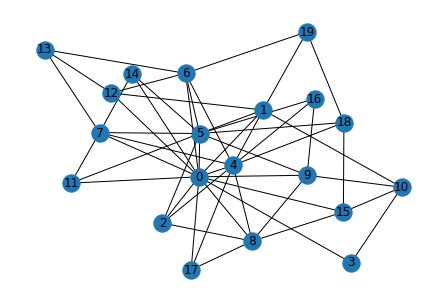

In [3]:
nx.draw(G, with_labels=True)
plt.show()

Estrazione della matrice di adiacenza A

In [4]:
adjacency = list(G.adjacency())
A = []
for a, b in adjacency :
    A += [[0]*len(adjacency)] 
    for c in b : 
        A[a][c] = 1

Estrazione della matrice di stocastica P

In [5]:
P = []
for a, b in adjacency :
    P += [[0]*len(adjacency)]
    for c in b: 
        P[a][c] = 1./G.degree[a]

In [6]:
matrix = np.array(P)
autovalori, autovettori = np.linalg.eig(np.transpose(matrix))
autovettori = np.transpose(autovettori)
pS = autovettori[0]
if pS[0] < 0:
    pS = -pS
#np.dot(np.transpose(matrix),autovettori[0])

Assegnazione degli individui ai nodi per l'evoluzione della dinamica. L'assegnazione degli individui è fatta secondo una distribuzione uniforme.

In [7]:
walker_per_node = 2
for n in G.nodes:
    G.nodes[n]['N_i'] = walker_per_node

In [8]:
seed = np.random.RandomState()
def dynamic_evolution(G, history = []):
    evolution = [0] * len(G.nodes)
    for n in G.nodes:
        for i in range(G.nodes[n]['N_i']):
            neighbours = list(G[n])
            new_node = _random_subset(neighbours, 1, seed).pop()
            evolution[new_node] += 1
    for n in G.nodes:
        G.nodes[n]['N_i'] = evolution[n]
    history += [evolution]

In [9]:
history = [[walker_per_node] * len(G.nodes)]
time_steps = int(2e5)

In [10]:
t0= time.time()

for t in range(time_steps):
    dynamic_evolution(G, history)

print(f"done in {int((time.time()-t0)/60)} minutes and {((time.time()-t0)%60)} seconds")

done in 2 minutes and 52.378807067871094 seconds


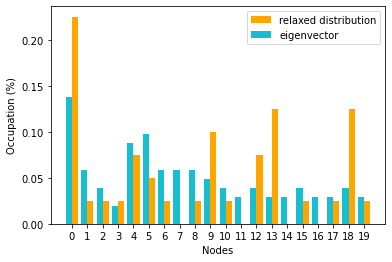

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)

# for n in range(100):
#     if n == 99:
#         plt.plot(G.nodes, [h/sum(history[len(history)-1]) for h in history[len(history)-1]], 'r', label = "relaxed distribution", alpha = 1)
#     else:
#         y = int(n * len(history) / 100)
#         plt.plot(G.nodes, [h/sum(history[y]) for h in history[y]], '#ca9bf7', label = "eigenvector", alpha = 0.05)
# plt.plot(G.nodes, [h/sum(pS) for h in pS], 'b' ,alpha = 1)

ax.bar(G.nodes, [h/sum(history[len(history)-1]) for h in history[len(history)-1]], width=0.4, 
       align='edge', color='orange', label = 'relaxed distribution')
ax.bar(G.nodes, [h/sum(pS) for h in pS], width=-0.4, align='edge', color='tab:cyan', label = "eigenvector")

plt.legend()
plt.xlabel("Nodes")
plt.ylabel("Occupation (%)")
# plt.grid(True)
ax.set_xticks(np.arange(0, N, 1))

plt.show()